# STAKEOUT ANALYSIS PREDICTING CRIME BY ZONE

This is the first analysis looking at crime in a certain area, breaking it into zones, and attempting to forecast the crime trends for those zones for 2015. 

In [647]:
import pandas as pd
import numpy as np
import datetime as datetime
import seaborn as sns
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import statsmodels.tsa.arima_model as arima
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.graphics.api import qqplot
from scipy import stats
import calendar

In [438]:
#reads in all 14 years of data and combines them into a single file (function from Wes McKinney's Python for Data Analysis)
years = range(2000,2015)

pieces = []
columns = ['When Reported','Offense Code','location']

for year in years:
    path = 'C:/Users/flunk_000/Desktop/CalPoly/StakeOut/%d.csv' % year
    frame = pd.read_csv(path, names=columns, header = True)

    pieces.append(frame)

crimeData = pd.concat(pieces, ignore_index=True)

#Total Crime/Day Time Series Creation

In [439]:
#rename zones in the data
for i in range(len(crimeData['location'])):
    if crimeData['location'][i] == 'LZ1':
        crimeData['location'][i]=1
    if crimeData['location'][i] =='LZ2':
        crimeData['location'][i]=2
    if crimeData['location'][i]=='LZ3':
        crimeData['location'][i]=3

In [440]:
#create a column of datetime values
crimeData['When Reported'] = [datetime.datetime.strptime(date, '%H:%M:%S %m/%d/%Y') for date in crimeData['When Reported']]

The data provided counted from 12-31 to 01-01 for each year individually, the following cell reorders the data chronologically so that they go from the first day of the year to the last day.

In [441]:
crimeData['When Reported'] = sorted(crimeData['When Reported'])

In [442]:
#creates a time series object of all crimes with the datetime they were reported
ts = pd.Series(crimeData['location'],index=crimeData['When Reported'])
ts[0:] = 1

In [443]:
#creates a new time series with the number of crimes that were reported each day
byDay = ts.resample('D',how='sum')

## Total Crime: Visualization

In [444]:
#save values for the plot
mean=round(np.mean(byDay),2)
std=round(np.std(byDay),2)

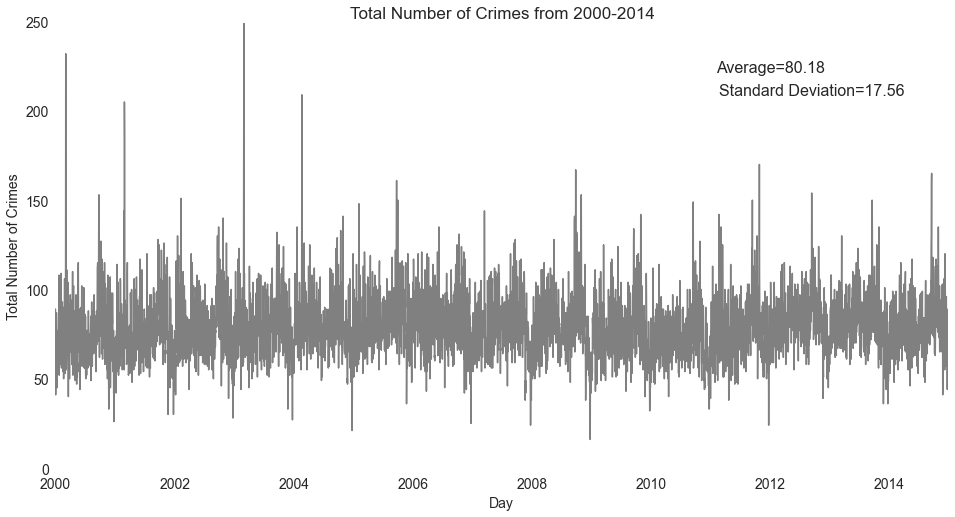

In [445]:
figure = plt.figure(figsize=(16,8))
TSPlot = byDay.plot(linewidth=1.5, c='gray')

TSPlot.set_ylabel('Total Number of Crimes', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Total Number of Crimes from 2000-2014',fontsize=17)
plt.tick_params(axis='both', labelsize=14)

#### ADD STATISTICS TEXT####
TSPlot.text(0.8, 0.9,'Average=%.2f' %mean, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16)
TSPlot.text(0.8465, 0.85,'Standard Deviation=%.2f' %std, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16);

#plt.savefig('total.png');

##Total Crime: Harmonic Model 

Based on the structure of the data, we decided the best approach was to identify the primary periods of the data (using Fast Fourier Transforms) to build a preliminary harmonic model that we hope to improve upon in the future.

In [446]:
#determine the fft values using the last 4096 days
ffts = {'Window':np.fft.fft(byDay[1383:5479])}

In [447]:
#create a dataframe of the fft values
harmonicDF = pd.DataFrame(ffts)

In [448]:
#function that converts the fft values into the peak amplitudes
def imabs(complexNum):
    return 2*abs(complexNum)/float(len(harmonicDF))

#function that converts the fft values into a phase shift for the cosine wave function
def imarg(complexNum):
    return math.atan2(complexNum.imag,complexNum.real)

In [449]:
#converts fft values to peak amplitudes
harmonicDF['peakAmps']= harmonicDF.apply(lambda row: imabs(row['Window']), axis=1)

In [450]:
#0 out the first amplitude
harmonicDF['peakAmps'][0] = 0
harmonicDF['peakAmps'][1023] = abs(harmonicDF['Window'][1023])

In [451]:
#create the wave numbers
harmonicDF['k'] = np.arange(len(harmonicDF))

In [452]:
#determine the frequencies by dividing wave number by length of the data set 
harmonicDF['freq'] = harmonicDF['k']/(len(harmonicDF))

In [453]:
#calculate the phase shifts
harmonicDF['phase(rad)']= harmonicDF.apply(lambda row: imarg(row['Window']), axis=1)

In [454]:
#create a second dataframe with only the amplitudes
peakDF = harmonicDF.filter(regex='peakAmps')

In [455]:
#create a dataframe for the sorted peaks to determine which frequencies should be used in harmonic model
peakDFsorted = peakDF.sort(['peakAmps'],ascending=False);
amp = peakDFsorted['peakAmps'][1:30]

In [456]:
#look at peaks to see the indicies and if they are consistent with the periodogram
amp.head()

585     9.196324
3511    9.196324
22      4.666792
4074    4.666792
4062    3.959619
Name: peakAmps, dtype: float64

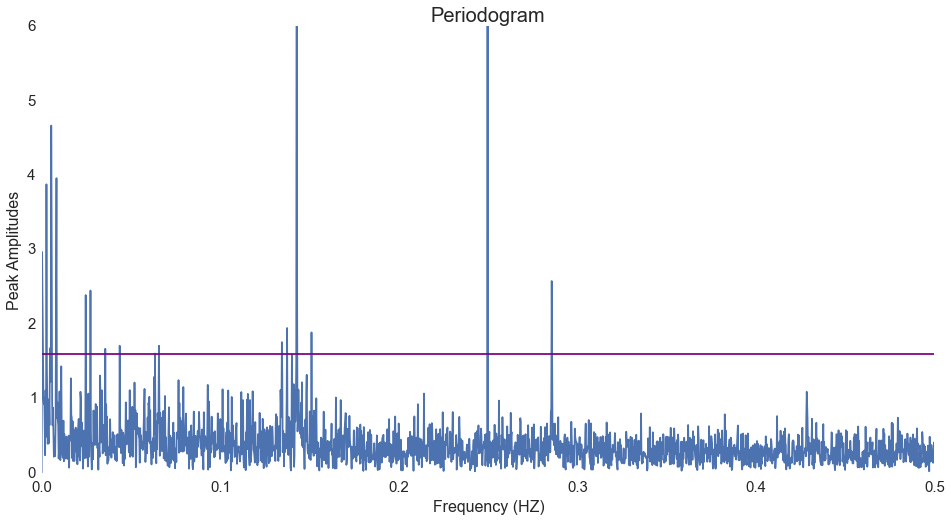

In [457]:
#Purple horizontal line was added after the initial creation of the periodogram
#We decided it was the best cut-off for the model frequencies
figure = plt.figure(figsize = (16,8))
plt.plot(harmonicDF['freq'], harmonicDF['peakAmps'])
plt.ylim(0,6)
plt.xlim(0,.5)
plt.axhline(1.6,0, color='purple')
plt.ylabel('Peak Amplitudes', fontsize = 16)
plt.xlabel('Frequency (HZ)', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Periodogram', fontsize = 20);

In [458]:
#check to see if the peak amplitudes selected for the model make sense in the context of the data
periods = []
for i in [585,22,34,11,23,1170,112,101,586,2,33,563,619,551,269,179,3,19,146]:
    periods.append(1/harmonicDF['freq'][i])
periods

[7.0017094017094017,
 186.18181818181819,
 120.47058823529412,
 372.36363636363637,
 178.08695652173913,
 3.5008547008547009,
 36.571428571428569,
 40.554455445544555,
 6.9897610921501707,
 2048.0,
 124.12121212121212,
 7.2753108348134994,
 6.6171243941841684,
 7.4337568058076222,
 15.226765799256505,
 22.882681564245811,
 1365.3333333333333,
 215.57894736842104,
 28.054794520547944]

In [459]:
#function to calculate the cosine waves for the harmonic model
def cos_wave(time,amp,freq,phi):
    return (amp*math.cos(2*math.pi*freq*time+phi))

In [460]:
#create a new dataframe for the cosine waves that will be generated 
index = pd.date_range('2000-01-01', periods=5479, freq='D')

#create a numerical time (instead of date time) for the cosine calculation
waveDF = pd.DataFrame(mdates.date2num(index), columns=['time'])
waveDF['When Reported'] = index

In [461]:
#calculates the cosine wave values to model the data
indices = [585,22,34,11,1170,112,101,619,269,179,19,146]
k=1

for j in range(len(indices2)):
    amp = harmonicDF['peakAmps'][indices[j]]
    freq = harmonicDF['freq'][indices[j]]
    phi = harmonicDF['phase(rad)'][indices[j]]
    
    waveDF['SineValues%d' %int(k)]= waveDF.apply(lambda row: cos_wave(row['time'],amp,freq,phi),axis=1)
    k+=1

In [462]:
#create a copy of the wave dataframe to sum the newly generated cos values
interval = waveDF.copy()

In [463]:
#remove the non-cos wave columns from the copied dataframe
del interval['time']
del interval['When Reported']

In [464]:
#create the aggregated wave from all the significant cos waves
waveDF['agWave'] = interval.sum(axis=1)

## Total Crime: Harmonic Model Visualization

In [465]:
#mean and std of only the data used to build the harmonic model
mean = np.mean(byDay[1383:5479])
std = np.std(byDay[1383:5479])

In [466]:
#create a time series of the aggregated wave
wave = pd.Series(waveDF['agWave'],index=waveDF['When Reported'])
wave[0:] = waveDF['agWave']+mean

In [467]:
#slice the data to use the 4096 days used for the harmonic model
wave = wave[1383:5479]

In [468]:
#total number of crimes for plotting
byDay2 = byDay[1383:5479]

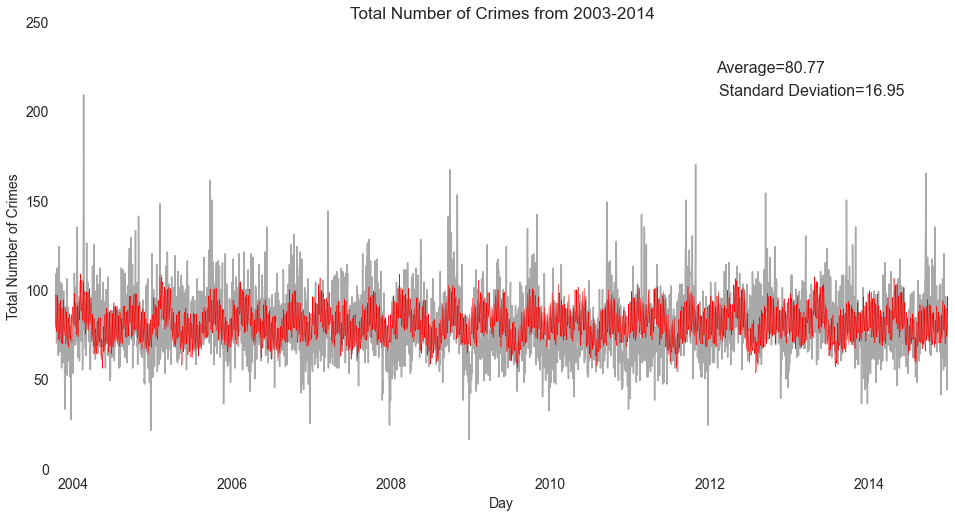

In [469]:
figure = plt.figure(figsize=(16,8))
TSPlot = byDay2.plot(linewidth=1.5, c='darkgray')
wave.plot(linewidth=.5,c='red')

TSPlot.set_ylabel('Total Number of Crimes', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Total Number of Crimes from 2003-2014',fontsize=17)
plt.tick_params(axis='both', labelsize=14)

#### ADD STATISTICS TEXT####
TSPlot.text(0.8, 0.9,'Average=%.2f' %mean, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16)
TSPlot.text(0.8465, 0.85,'Standard Deviation=%.2f' %std, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 16);

In [470]:
#function to calculate the residuals for ARIMA modeling
def calc_resid(obs,pred):
    return obs-pred

In [471]:
#add the total number of crime per day to the dataframe
waveDF['byDay'] = byDay
for i in range(len(waveDF)):
    waveDF['byDay'][i] = byDay[i]

In [472]:
#create a column of the residuals
waveDF['Residuals']= waveDF2.apply(lambda row: calc_resid(row['agWave'],row['byDay']), axis=1)
waveDF['Residuals']= waveDF2['Residuals']+mean

In [474]:
#create a dataframe with only the 4096 days we've been working with
waveDF4096 = waveDF[1383:5479]

In [480]:
#create a time series of the residuals for easy plotting
toArima = pd.Series(waveDF4096['Residuals'], index=waveDF4096['When Reported'])
toArima[0:] = waveDF4096['Residuals']-mean

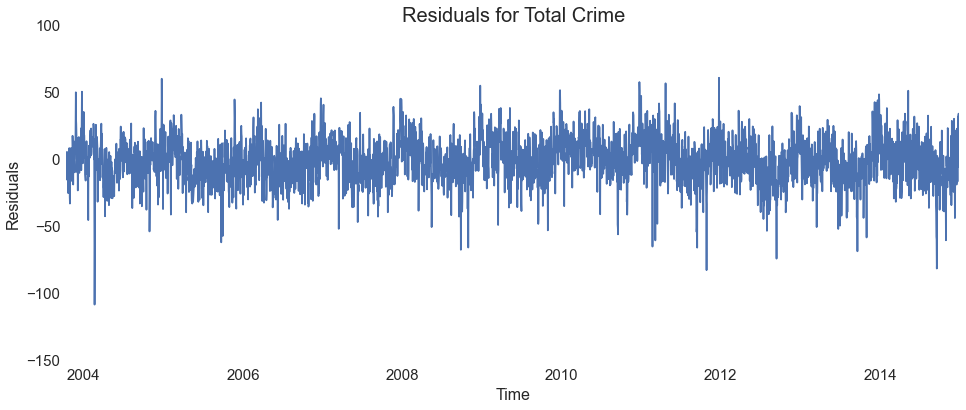

In [481]:
#plot the residuals
fig = plt.figure(figsize=(16,6))
toArima.plot()

plt.ylabel('Residuals', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Residuals for Total Crime', fontsize = 20);

## NOTE:

This section was primarily for developing and testing the code required to investigate crime by zone and type of crime within zone. The next section will start with crime by zone. The model for total crime and its forecast will be generated from the smaller and more accurate zone models.

# Total Crime/Day, by Zone 

In [482]:
#subset the data into zones
z1 = crimeData.query('location == 1')
z2 = crimeData.query('location == 2')
z3 = crimeData.query('location == 3')

In [483]:
#total number of crimes for each zone
print('Total crime for zone 1:',len(z1));print('Total crime for zone 2:',len(z2));print('Total crime for zone 3:',(len(z3)))

('Total crime for zone 1:', 167318)
('Total crime for zone 2:', 176247)
('Total crime for zone 3:', 75107)


In [484]:
#reindex the data to reorder the indicies
z1 = z1.reset_index();
z2 = z2.reset_index();
z3 = z3.reset_index();

In [485]:
#remove the extraneous index columns created
del z1['index']
del z2['index']
del z3['index']

In [486]:
#create a time series for each zone
z1TS = pd.Series(z1['location'],index=z1['When Reported'])
z1TS[0:] = 1

z2TS = pd.Series(z2['location'],index=z2['When Reported'])
z2TS[0:] = 1

z3TS = pd.Series(z3['location'],index=z3['When Reported'])
z3TS[0:] = 1

In [487]:
#create a time series for each zone with number of crimes reported each day
z1TS = z1TS.resample('D',how='sum')
z2TS = z2TS.resample('D',how='sum')
z3TS = z3TS.resample('D',how='sum')

## Crime by Zone: Visualization

In [488]:
#descriptive statistics for plotting, and for centering residuals on the data
z1mean = round(np.mean(z1TS),2)
z1std = round(np.std(z1TS),2)

z2mean = round(np.mean(z2TS),2)
z2std = round(np.std(z2TS),2)

z3mean = round(np.mean(z3TS),2)
z3std = round(np.std(z3TS),2)

In [489]:
#used to make multiple graphs in the same plot
from matplotlib.gridspec import GridSpec

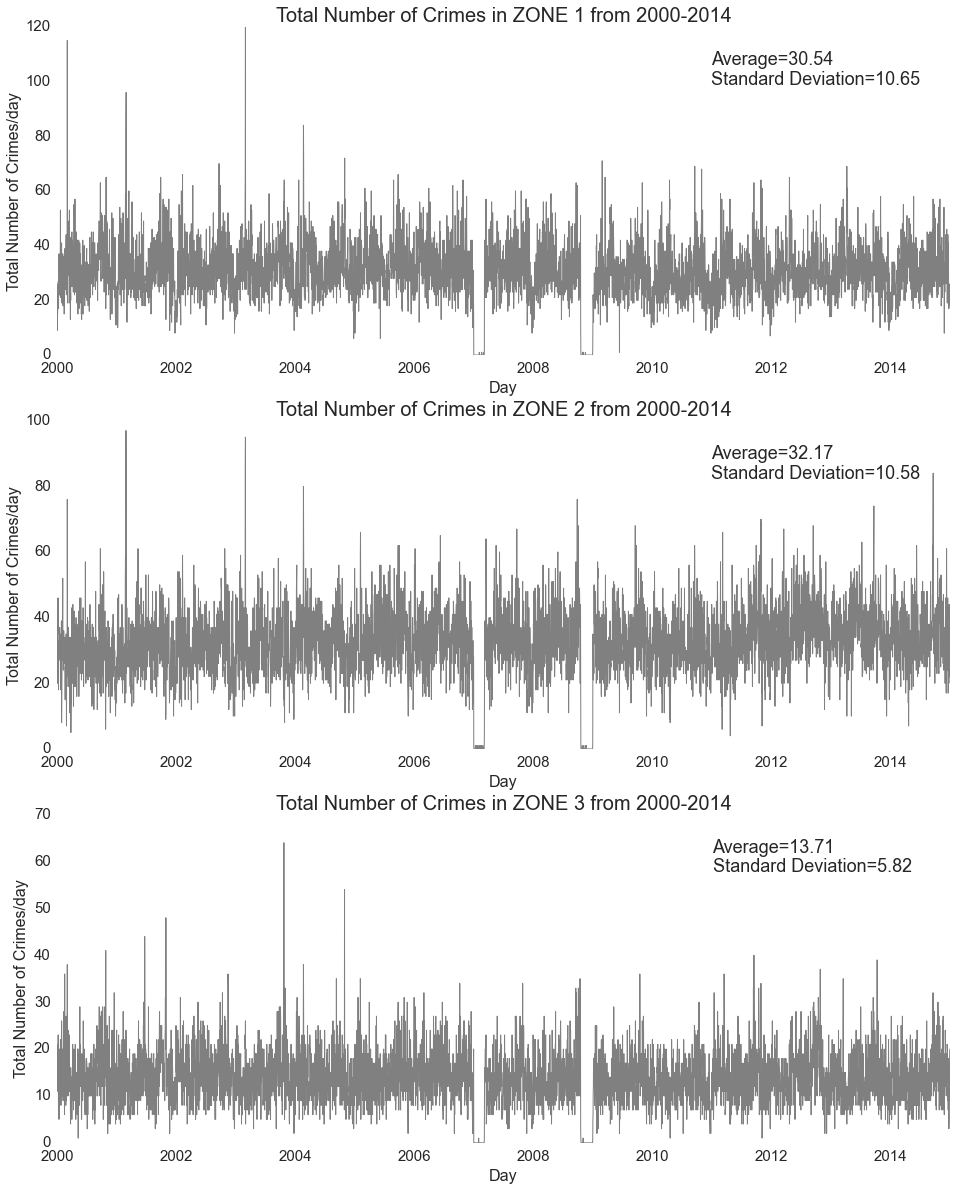

In [491]:
figure = plt.figure(figsize=(16,20))
gs = GridSpec(3,1)

#code to plot the time series for zone 1
z1plot = figure.add_subplot(gs[0,0])
z1plot =z1TS.plot(linewidth=1, c='gray')
z1plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z1plot.set_xlabel('Day',fontsize=16)
z1plot.set_title('Total Number of Crimes in ZONE 1 from 2000-2014',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.text(0.8, 0.9,'Average=%.2f' %z1mean, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18)
z1plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z1std, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18);

#code to plot the time series for zone 2
z2plot = figure.add_subplot(gs[1,0])
z2plot = z2TS.plot(linewidth=1, c='gray')
z2plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z2plot.set_xlabel('Day',fontsize=16)
z2plot.set_title('Total Number of Crimes in ZONE 2 from 2000-2014',fontsize=20)
z2plot.tick_params(axis='both', labelsize=15)
z2plot.text(0.8, 0.9,'Average=%.2f' %z2mean, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18)
z2plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z2std, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18);

#code to plot the time series for zone 3
z3plot = figure.add_subplot(gs[2,0])
z3plot = z3TS.plot(linewidth=1, c='gray')
z3plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z3plot.set_xlabel('Day',fontsize=16)
z3plot.set_title('Total Number of Crimes in ZONE 3 from 2000-2014',fontsize=20)
z3plot.tick_params(axis='both', labelsize=15)
z3plot.text(0.8, 0.9,'Average=%.2f' %z3mean, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18)
z3plot.text(0.846, 0.84,'Standard Deviation=%.2f' %z3std, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18);

#this line will output the plot as a png, if necessary
#plt.savefig('zone.png');

Looking at the crime by zone, we see that there are missing sections of data in roughly 2007 and 2009. Rather than going trough an imputation process, we decided to use the most recent 2048 days for the harmonic model.

##Crime by Zone: Harmonic Model 

In [493]:
#slice the time series for the most recent 2048
z1TS = z1TS[3431:5497]
z2TS = z2TS[3431:5497]
z3TS = z3TS[3431:5497]

In [494]:
#used to reposition the aggregated wave to the model and for descriptive statistics
z1mean = np.mean(z1TS)
z2mean = np.mean(z2TS)
z3mean = np.mean(z3TS)

z1std = np.std(z1TS)
z2std = np.std(z2TS)
z3std = np.std(z3TS)

### The aggregated wave for the harmonic models for each zone were computed in their own notebooks and sent to a csv file. This is essentially the same process demonstrated above with total crime, but was removed to reduce the length of this analysis.

In [495]:
#read the data in from csv
waveDFz1 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone1.csv')

In [496]:
#create the aggregated wave time series, similar to how total crime was done above
wavez1 = pd.Series(waveDFz1['agWave'],index=waveDFz1['When Reported'])
wavez1[0:] = waveDFz1['agWave']+z1mean

In [498]:
#create the 2048 slice used for the by zone FFTs
wavez1 = wavez1[3431:5497]

Rinse and repeat for zone 2.

In [499]:
waveDFz2 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone2.csv')

In [500]:
wavez2 = pd.Series(waveDFz2['agWave'],index=waveDFz2['When Reported'])
wavez2[0:] = waveDFz2['agWave']+z2mean

In [501]:
wavez2 = wavez2[3431:5497]

Rinse and repeat for zone 3.

In [502]:
waveDFz3 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone3.csv')

In [503]:
wavez3 = pd.Series(waveDFz3['agWave'],index=waveDFz3['When Reported'])
wavez3[0:] = waveDFz3['agWave']+z3mean

In [504]:
wavez3 = wavez3[3431:5497]

## Base of Harmonic Model Visualization for Zones 1-3

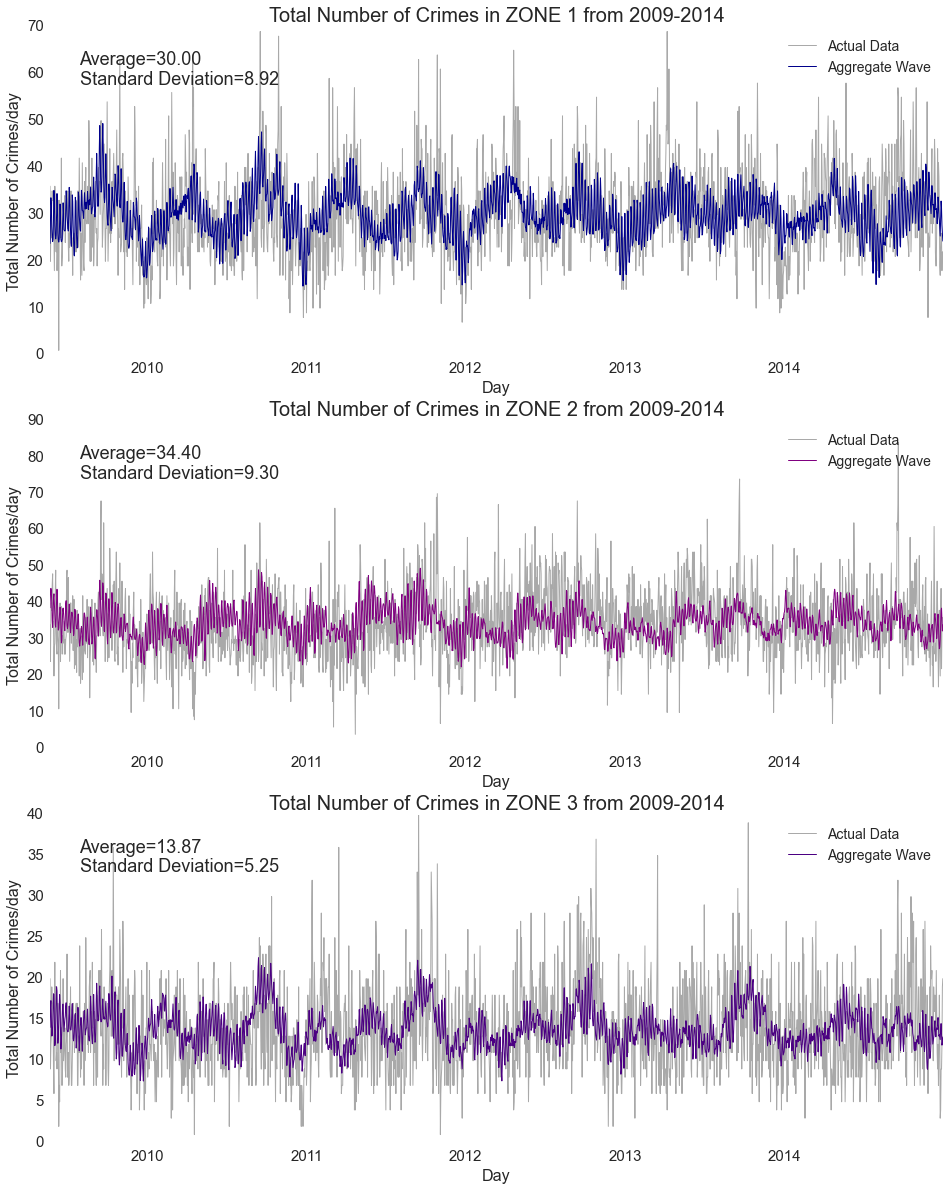

In [522]:
figure = plt.figure(figsize=(16,20))
gs = GridSpec(3,1)

z1plot = figure.add_subplot(gs[0,0])
z1plot =z1TS.plot(linewidth=1, c='darkgray')
z1plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
wavez1.plot(linewidth=1,c='darkblue');
z1plot.set_xlabel('Day',fontsize=16)
z1plot.set_title('Total Number of Crimes in ZONE 1 from 2009-2014',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.legend(['Actual Data','Aggregate Wave'], fontsize = 14)
z1plot.text(0.1, 0.9,'Average=%.2f' %z1mean, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18)
z1plot.text(0.145, 0.84,'Standard Deviation=%.2f' %z1std, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18);

z2plot = figure.add_subplot(gs[1,0])
z2plot = z2TS.plot(linewidth=1, c='darkgray')
wavez2.plot(linewidth=1,c='purple');
z2plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z2plot.set_xlabel('Day',fontsize=16)
z2plot.set_title('Total Number of Crimes in ZONE 2 from 2009-2014',fontsize=20)
z2plot.tick_params(axis='both', labelsize=15)
z2plot.legend(['Actual Data','Aggregate Wave'], fontsize = 14)
z2plot.text(0.1, 0.9,'Average=%.2f' %z2mean, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18)
z2plot.text(0.145, 0.84,'Standard Deviation=%.2f' %z2std, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18);

z3plot = figure.add_subplot(gs[2,0])
z3plot = z3TS.plot(linewidth=1, c='darkgray')
wavez3.plot(linewidth=1,c='indigo');
z3plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z3plot.set_xlabel('Day',fontsize=16)
z3plot.set_title('Total Number of Crimes in ZONE 3 from 2009-2014',fontsize=20)
z3plot.tick_params(axis='both', labelsize=15)
z3plot.legend(['Actual Data','Aggregate Wave'], fontsize = 14)
z3plot.text(0.1, 0.9,'Average=%.2f' %z3mean, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18)
z3plot.text(0.145, 0.84,'Standard Deviation=%.2f' %z3std, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18);

#plt.savefig('zoneM.png');

# Perform ARIMA on the Residuals from the aggregate waves

In [506]:
#calculate the residuals for each zone
toArimaZ1 = calc_resid(z1TS,wavez1)
toArimaZ2 = calc_resid(z2TS,wavez2)
toArimaZ3 = calc_resid(z3TS,wavez3)

### Visualize Residuals to investigate unaccounted for periodicity

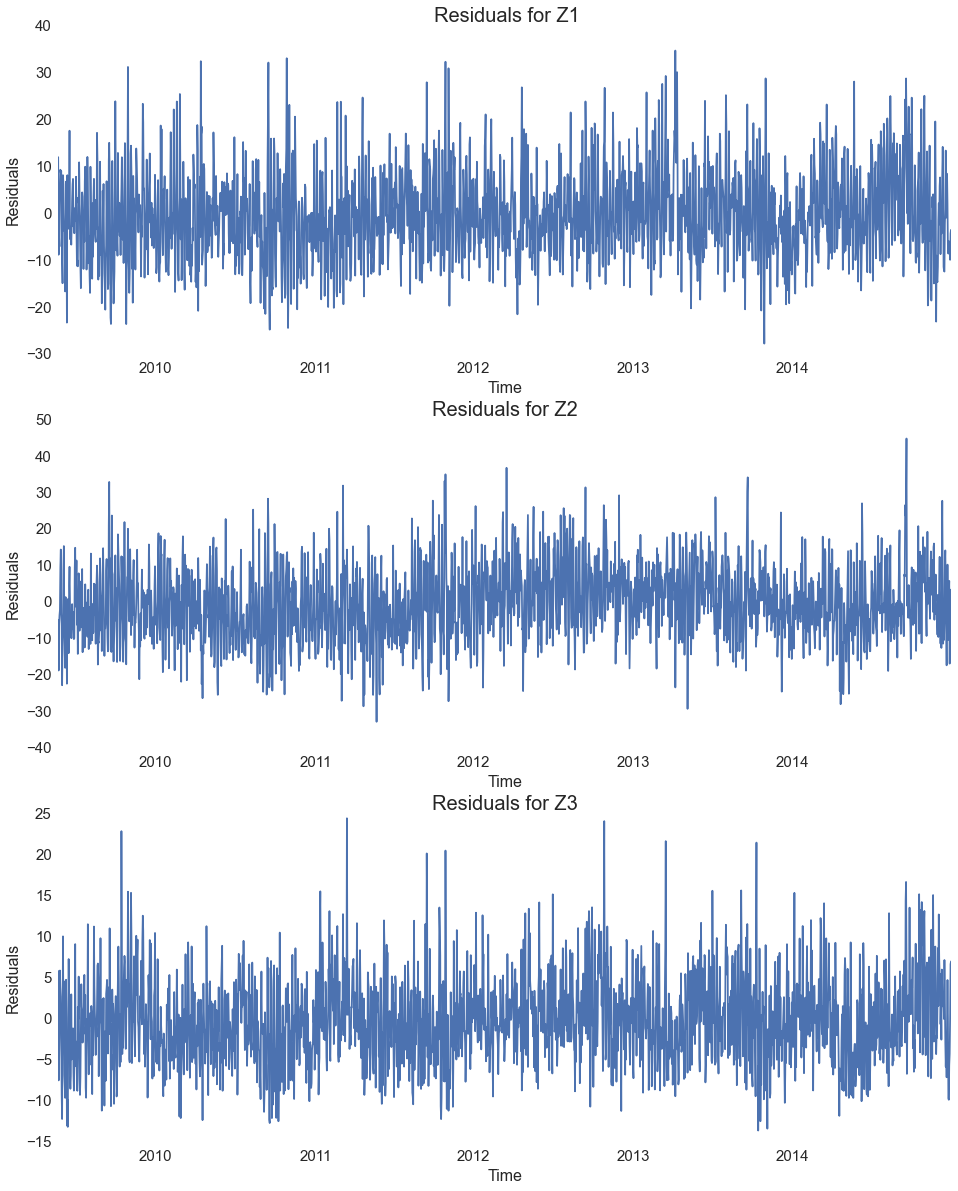

In [525]:
figure = plt.figure(figsize=(16,20))
gs = GridSpec(3,1)

z1plot = figure.add_subplot(gs[0,0])
toArimaZ1.plot()
z1plot.set_ylabel('Residuals', fontsize = 16)
z1plot.set_xlabel('Time', fontsize = 16)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.set_title('Residuals for Z1', fontsize = 20);

z2plot = figure.add_subplot(gs[1,0])
toArimaZ2.plot()
z2plot.set_ylabel('Residuals', fontsize = 16)
z2plot.set_xlabel('Time', fontsize = 16)
z2plot.tick_params(axis='both', labelsize=15)
z2plot.set_title('Residuals for Z2', fontsize = 20);

z3plot = figure.add_subplot(gs[2,0])
toArimaZ3.plot()
z3plot.set_ylabel('Residuals', fontsize = 16)
z3plot.set_xlabel('Time', fontsize = 16)
z3plot.tick_params(axis='both', labelsize=15)
z3plot.set_title('Residuals for Z3', fontsize = 20);

# STATSMODELS ARIMA

## ZONE 1 Model

In [553]:
tsa.stattools.arma_order_select_ic(toArimaZ1)

C:\Users\flunk_000\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'bic':               0             1             2
 0  14992.788694  14702.174343  14667.825175
 1  14701.553868  14689.561965  14673.717212
 2  14667.771977  14625.202107  14362.386634
 3  14576.213755  14576.741707  14263.163465
 4  14567.092350  14538.501177  14268.356890, 'bic_min_order': (3, 2)}

Similar to the previous section, these errors are new. We chose to stick with the ARMA 4,2 since that was the model it fit before the errors started.

In [558]:
z1Arima = arima.ARIMA(toArimaZ1, order=(3,0,2)).fit()
fits1 = z1Arima.fittedvalues

In [561]:
sm.stats.durbin_watson(z1Arima.resid.values)

2.0174538039897492

With a DW statisic in the center, between 0 and 4, it appears we do not have any positive or negative autocorrelation left.

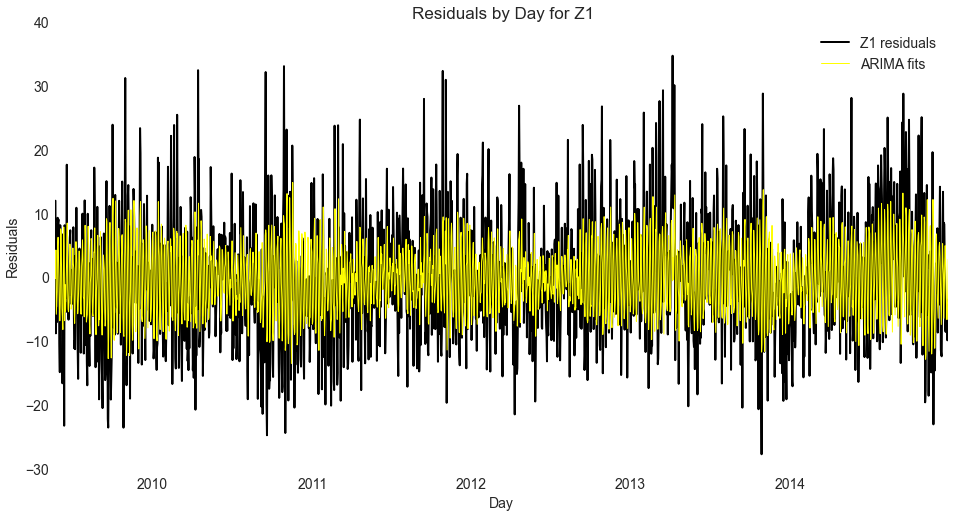

In [560]:
figure = plt.figure(figsize=(16,8))
TSPlot = toArimaZ1.plot(linewidth=2, c='black')
fits1.plot(linewidth=1,c='yellow')

TSPlot.set_ylabel('Residuals', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Residuals by Day for Z1',fontsize=17)
plt.legend(['Z1 residuals','ARIMA fits'], fontsize = 14)
plt.tick_params(axis='both', labelsize=14)

Doesn't do a great job, but appears to capture enough for this first run.

In [562]:
#add together the aggregate wave times series and the ARIMA fit time series
plotMe1 = fits1 + wavez1

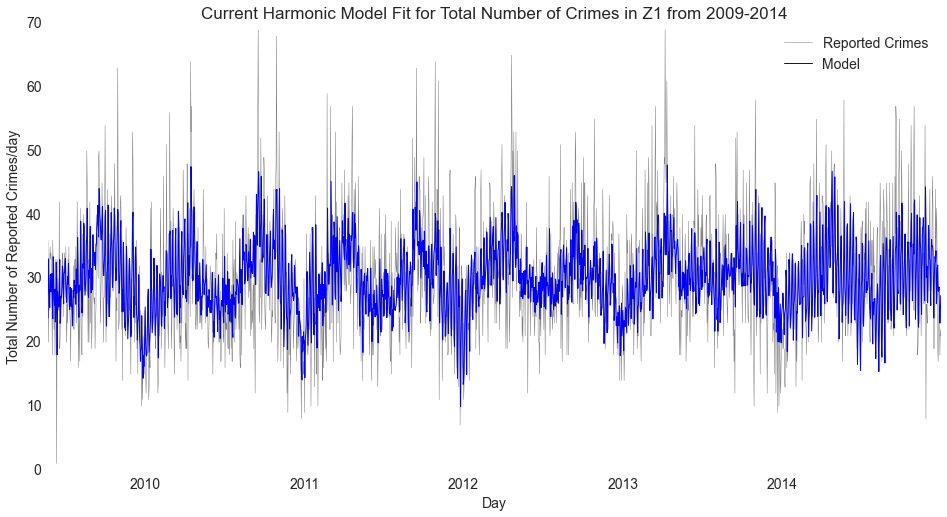

In [715]:
figure = plt.figure(figsize=(16,8))
TSPlot = z1TS.plot(linewidth=.5, c='gray')
plotMe1.plot(linewidth=1,c='blue')

TSPlot.set_ylabel('Total Number of Reported Crimes/day', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Current Harmonic Model Fit for Total Number of Crimes in Z1 from 2009-2014',fontsize=17)
plt.legend(['Reported Crimes','Model'], fontsize = 14)


plt.tick_params(axis='both', labelsize=14)

Overall, this model looks good for a first run of Zone 1.

## ZONE 2 Model (Repeat of Zone 1)

In [566]:
tsa.stattools.arma_order_select_ic(toArimaZ2)

{'bic':               0             1             2
 0  15339.703454  15047.650756  15017.023074
 1  15042.608918  15033.712269  15010.203165
 2  15018.538675  14992.732281  14744.377555
 3  14959.783948  14963.239735  14666.316046
 4  14957.552288  14877.350145  14666.915579, 'bic_min_order': (3, 2)}

Before the update from statsmodels, this function was claiming a ARMA(4,2) fit was better. Sticking with the original ARMA fit does give a lower Durbin-Watson and better fit

In [582]:
z2Arima = arima.ARIMA(toArimaZ2, order=(4,0,2)).fit()
fits2 = z2Arima.fittedvalues

In [583]:
sm.stats.durbin_watson(z2Arima.resid.values)

2.0085075699281401

There does not appear to be any autocorrelation left.

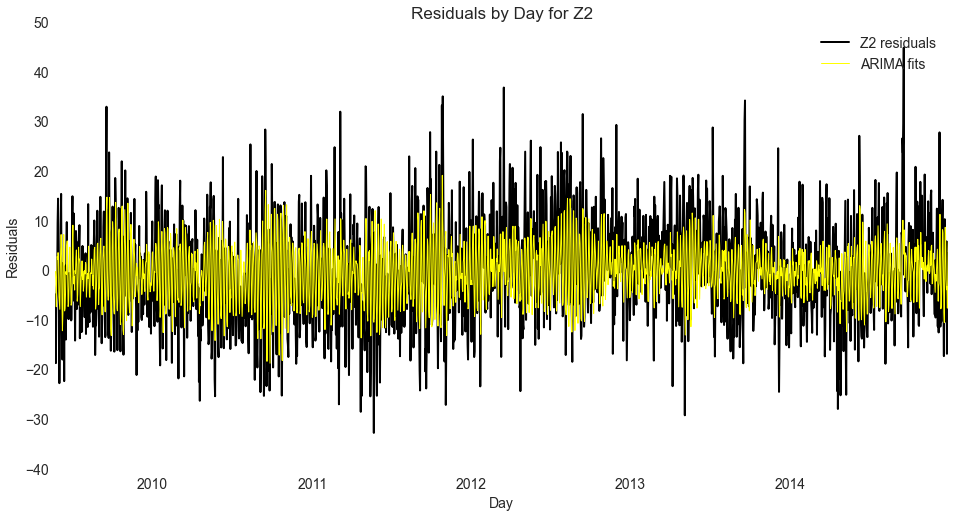

In [584]:
figure = plt.figure(figsize=(16,8))
TSPlot = toArimaZ2.plot(linewidth=2, c='black')
fits2.plot(linewidth=1,c='yellow')

TSPlot.set_ylabel('Residuals', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Residuals by Day for Z2',fontsize=17)
plt.legend(['Z2 residuals','ARIMA fits'], fontsize = 14)
plt.tick_params(axis='both', labelsize=14)

In [585]:
plotMe2 = fits2 + wavez2

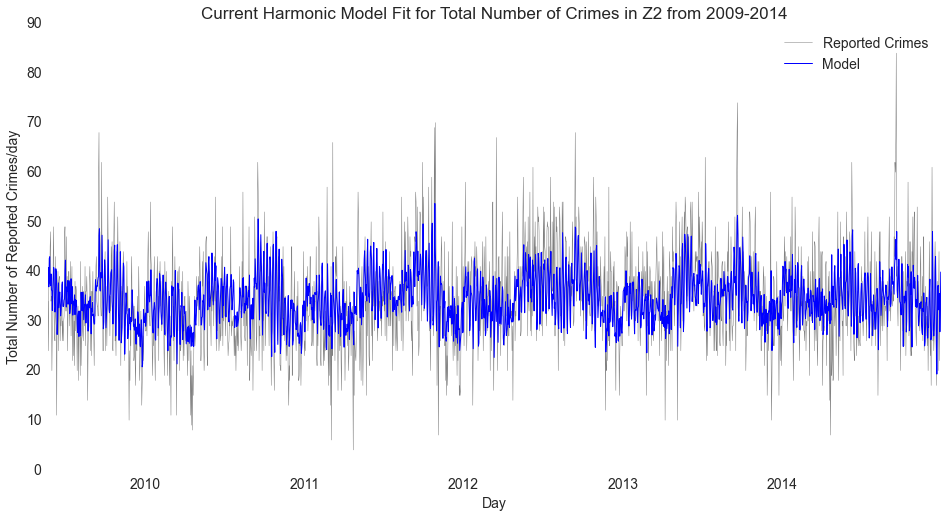

In [714]:
figure = plt.figure(figsize=(16,8))
TSPlot = z2TS.plot(linewidth=.5, c='gray')
plotMe2.plot(linewidth=1,c='blue')

TSPlot.set_ylabel('Total Number of Reported Crimes/day', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Current Harmonic Model Fit for Total Number of Crimes in Z2 from 2009-2014',fontsize=17)
plt.legend(['Reported Crimes','Model'], fontsize = 14)

plt.tick_params(axis='both', labelsize=14)

## ZONE 3 (Repeat of Zones 1 and 2)

In [589]:
tsa.stattools.arma_order_select_ic(toArimaZ3)

{'bic':               0             1             2
 0  12687.558270  12528.251117  12527.945053
 1  12525.319411  12529.792759  12497.251152
 2  12528.469446  12532.900586  12476.849905
 3  12528.105299  12495.108821  12385.735234
 4  12533.250588  12465.255374  12385.296913, 'bic_min_order': (4, 2)}

In [590]:
z3Arima = arima.ARIMA(toArimaZ3, order=(4,0,2)).fit()
fits3 = z3Arima.fittedvalues

In [591]:
sm.stats.durbin_watson(z3Arima.resid.values)

2.0095608765936146

There appears to be no autocorrelation left.

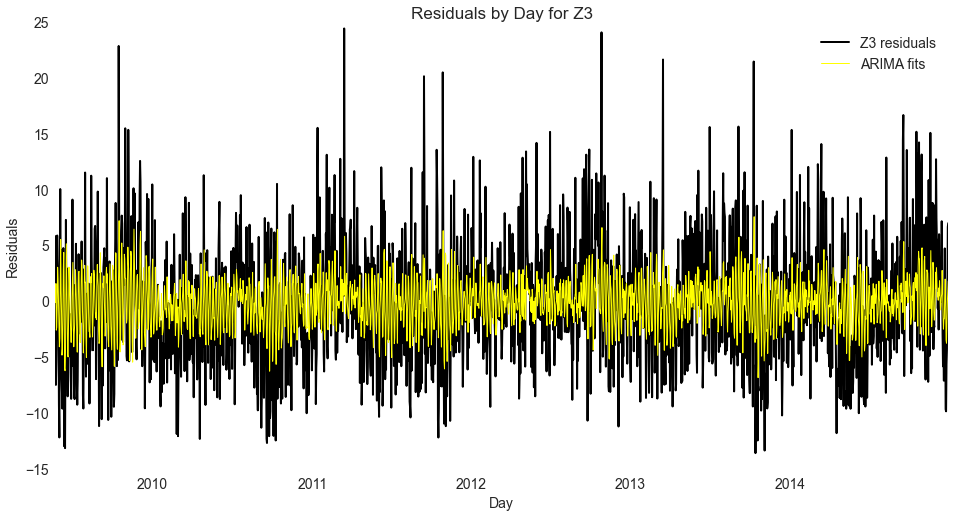

In [592]:
figure = plt.figure(figsize=(16,8))
TSPlot = toArimaZ3.plot(linewidth=2, c='black')
fits3.plot(linewidth=1,c='yellow')

TSPlot.set_ylabel('Residuals', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Residuals by Day for Z3',fontsize=17)
plt.legend(['Z3 residuals','ARIMA fits'], fontsize = 14)
plt.tick_params(axis='both', labelsize=14)

In the future, we want to explain more of the behavior in the residuals for Zone 3.

In [593]:
plotMe3 = fits3 + wavez3

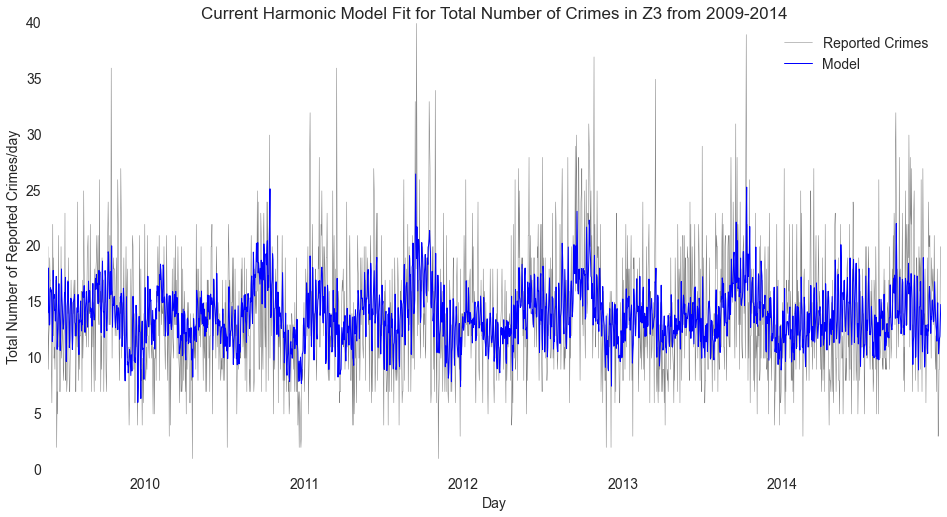

In [713]:
figure = plt.figure(figsize=(16,8))
TSPlot = z3TS.plot(linewidth=.5, c='gray')
plotMe3.plot(linewidth=1,c='blue')

TSPlot.set_ylabel('Total Number of Reported Crimes/day', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Current Harmonic Model Fit for Total Number of Crimes in Z3 from 2009-2014',fontsize=17)
plt.tick_params(axis='both', labelsize=14)
plt.legend(['Reported Crimes','Model'], fontsize = 14);

Overall, it appears that all 3 models we have generated (zones 1,2, and 3) are conservative. We are accounting for a lot of information, but not all that we might be able to.

## ZONE 1 Forecast

In [609]:
#these files for zones 1,2, and 3 come from the notebooks that were used to create the harmonic models for those zones
#they are mentioned earlier in this notebook and essentially repeated what was done to model total crime in the beginning
forecastDFz1 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone1Forecast.csv')

In [610]:
#this is wavez1 with the extra year (2015) added on (ie length 2413 instead of 2048)
forecastz1 = pd.Series(forecastDFz1['agWave'],index=forecastDFz1['When Reported'])
forecastz1[0:] = forecastDFz1['agWave']+z1mean

In [611]:
#predict the residuals for 2015
predicts1 = z1Arima.predict('2015-01-01', '2015-12-31', dynamic=True)

In [617]:
#create a new times series of the harmonic model from the previous section to add in the model + forecasted residuals
forecastFits = pd.Series(fits1,index=forecastDFz1['When Reported'])
for i in np.arange(len(forecastFits)-365):
    forecastFits[i] = fits1[i]+wavez1[i]

In [618]:
#add forecasted residuals to the aggregate wave model
forecastSum = predicts1['2015-01-01':] + forecastz1['2015-01-01':]

In [619]:
#add 2015 to the time series
forecastFits['2015-01-01':] = forecastSum

In [620]:
#these are the lower and upper 80% confidence bounds from R
#couldn't figure out how to get the error bounds from statsmodels
z1bound = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone1bounds.csv')

In [621]:
#set the length of time pertaining to just the confidence bounds
boundTime = forecastDFz1['When Reported'][(len(forecastDFz1)-365):]

In [622]:
#create the lower bound time series for plotting
z1lower = pd.Series(z1bound['v1'],index=boundTime)
for i in np.arange(len(z1lower)):
    z1lower[i]= z1bound['v1'][i]+forecastSum[i]

In [623]:
#run a moving average to smooth the bounds for plotting
z1lower = pd.rolling_window(z1lower,20, 'boxcar', center=True)

In [624]:
z1upper = pd.Series(z1bound['v2'],index=boundTime)
for i in np.arange(len(z1upper)):
    z1upper[i]= z1bound['v2'][i]+forecastSum[i]

In [625]:
z1upper = pd.rolling_window(z1upper,20, 'boxcar', center=True)

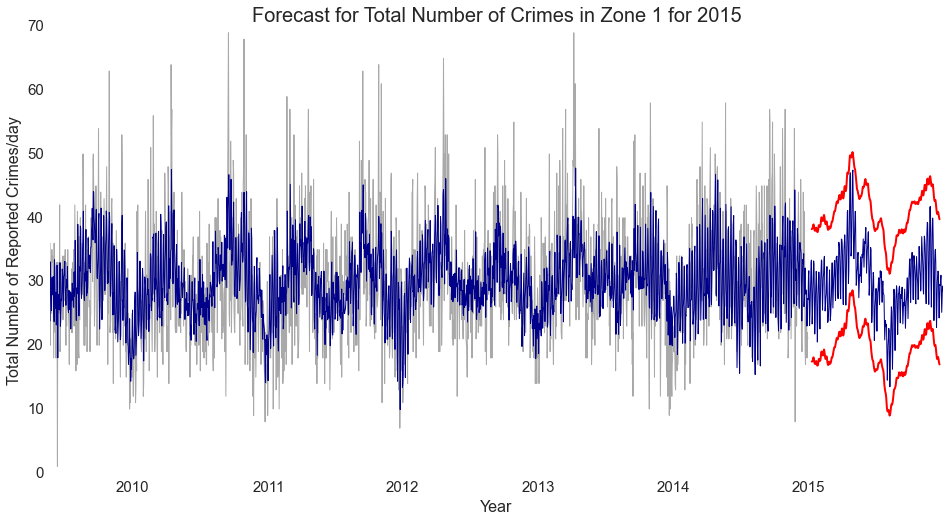

In [706]:
figure = plt.figure(figsize=(16,8))
z1plot =z1TS.plot(linewidth=1, c='darkgray')
z1plot.set_ylabel('Total Number of Reported Crimes/day', fontsize=16)
forecastFits.plot(linewidth=1,c='darkblue');
z1lower.plot(linewidth=2,c='red');
z1upper.plot(linewidth=2,c='red');
z1plot.set_xlabel('Year',fontsize=16)
z1plot.set_title('Forecast for Total Number of Crimes in Zone 1 for 2015',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)

Once again, this is a suprisingly conservative forecast. It appears that an element of the data yields very accurate forecasts, or R's bounds are not decreasing their accuracy with each step.

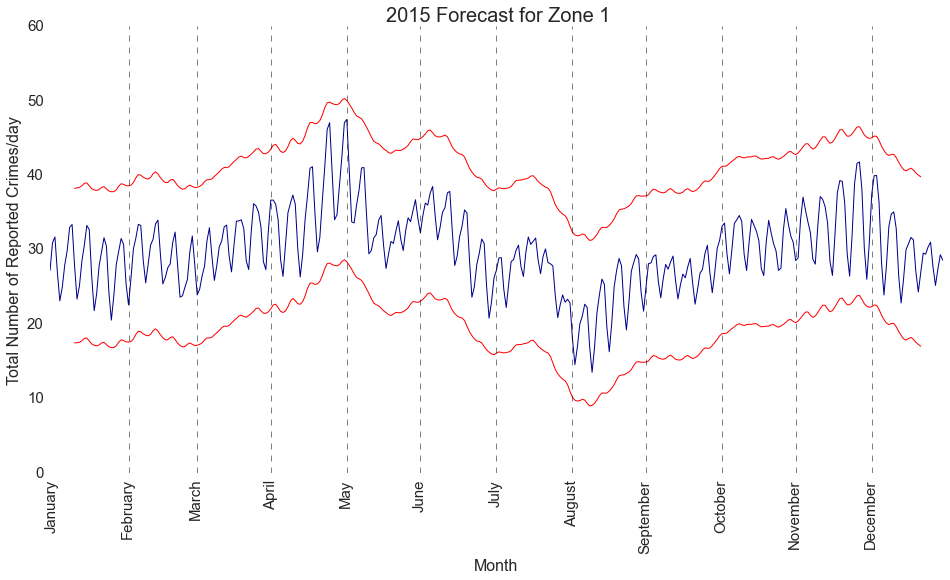

In [707]:
figure = plt.figure(figsize=(16,8))
zoom = forecastFits[(len(forecastFits)-365):]
zoom = pd.Series(forecastFits[(len(forecastFits)-365):], index = forecastDFz1['When Reported'][(len(forecastDFz1)-365):])
zoom[0:] = forecastFits[(len(forecastFits)-365):]
z1lower.plot(linewidth=1,c='red');
z1upper.plot(linewidth=1,c='red');

z1plot = zoom.plot(linewidth=1,c='darkblue');
z1plot.set_ylabel('Total Number of Reported Crimes/day', fontsize=16)
z1plot.set_xlabel('Month',fontsize=16)
z1plot.set_title('2015 Forecast for Zone 1',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)

xlabels = ['January','February','March','April','May','June','July','August','September','October','November','December']
xticks = [1,32,60,90,121,151,182,213,243,274,304,335]

z1plot.set_xticklabels(xlabels, rotation=90, fontsize=15)
z1plot.set_xticks(xticks);

for i in [32,60,90,121,151,182,213,243,274,304,335]:
    plt.axvline(i,0, color='black', ls = '--', linewidth=.5)

#Zone 2 Forecast 

In [683]:
forecastDFz2 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone2Forecast.csv')

In [684]:
forecastz2 = pd.Series(forecastDFz2['agWave'],index=forecastDFz2['When Reported'])
forecastz2[0:] = forecastDFz2['agWave']+z2mean

In [685]:
predicts2 = z2Arima.predict('2015-01-01', '2015-12-31', dynamic=True)

In [686]:
forecastFits2 = pd.Series(fits2,index=forecastDFz2['When Reported'])
forecastFits2[0:] = fits2+forecastz2

In [687]:
forecastSum2= predicts2['2015-01-01':] + forecastz2['2015-01-01':]

In [688]:
forecastFits2['2015-01-01':] = forecastSum2

In [689]:
z2bound = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone2bounds.csv')

In [690]:
boundTime2 = forecastDFz2['When Reported'][(len(forecastDFz2)-365):]

In [691]:
z2lower = pd.Series(z2bound['v1'],index=boundTime2)
for i in np.arange(len(z1lower)):
    z2lower[i]= z2bound['v1'][i]+forecastSum2[i]

In [692]:
z2lower = pd.rolling_window(z2lower,20, 'boxcar', center=True)

In [693]:
z2upper = pd.Series(z2bound['v2'],index=boundTime2)
for i in np.arange(len(z2upper)):
    z2upper[i]= z2bound['v2'][i]+forecastSum2[i]

In [694]:
z2upper = pd.rolling_window(z2upper,20, 'boxcar', center=True)

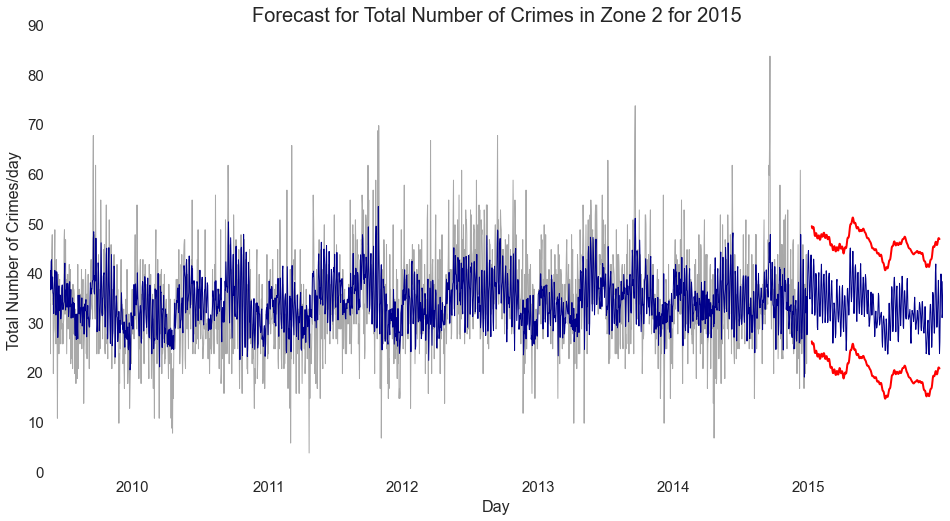

In [711]:
figure = plt.figure(figsize=(16,8))
z1plot =z2TS.plot(linewidth=1, c='darkgray')
z1plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
forecastFits2.plot(linewidth=1,c='darkblue');
z2lower.plot(linewidth=2,c='red');
z2upper.plot(linewidth=2,c='red');
z1plot.set_xlabel('Day',fontsize=16)
z1plot.set_title('Forecast for Total Number of Crimes in Zone 2 for 2015',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)

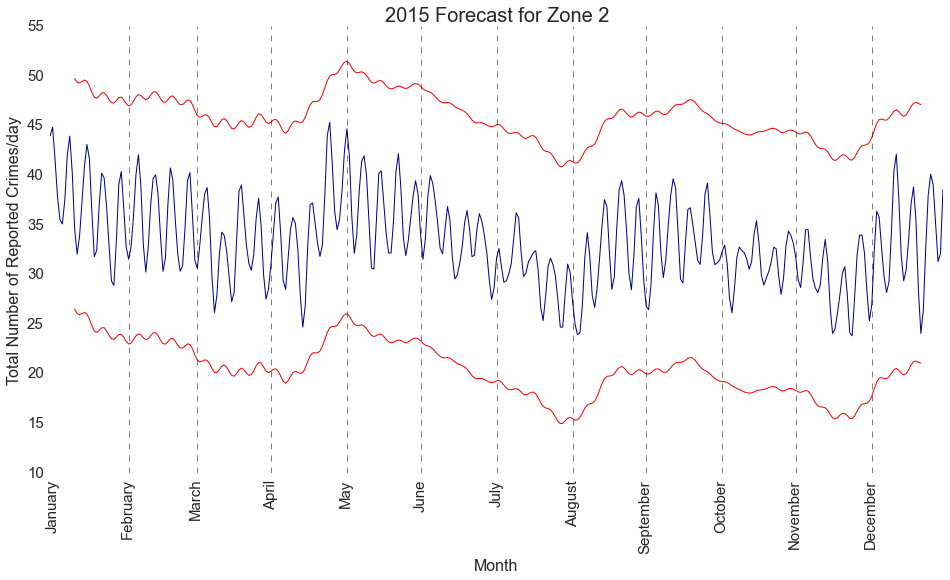

In [746]:
figure = plt.figure(figsize=(16,8))
zoom2 = forecastFits2[(len(forecastFits2)-365):]
zoom2 = pd.Series(forecastFits2[(len(forecastFits2)-365):], index = forecastDFz1['When Reported'][(len(forecastDFz1)-365):])
zoom2[0:] = forecastFits2[(len(forecastFits2)-365):]
z2lower.plot(linewidth=1,c='red');
z2upper.plot(linewidth=1,c='red');

z1plot = zoom2.plot(linewidth=1,c='darkblue');
z1plot.set_xlabel('Month',fontsize=16)
z1plot.set_title('2015 Forecast for Zone 2',fontsize=20)
z1plot.set_ylabel('Total Number of Reported Crimes/day', fontsize=16)
z1plot.tick_params(axis='both', labelsize=15)

xlabels = ['January','February','March','April','May','June','July','August','September','October','November','December']
xticks = [1,32,60,90,121,151,182,213,243,274,304,335]

z1plot.set_xticklabels(xlabels, rotation=90, fontsize=15)
z1plot.set_xticks(xticks);

for i in [32,60,90,121,151,182,213,243,274,304,335]:
    plt.axvline(i,0, color='black', ls = '--', linewidth=.5)

In [297]:
forecastDFz3 = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone3Forecast.csv')

In [298]:
forecastz3 = pd.Series(forecastDFz3['agWave'],index=forecastDFz3['When Reported'])
forecastz3[0:] = forecastDFz3['agWave']+z3mean

In [299]:
predicts3 = z3Arima.predict('2015-01-01', '2015-12-31', dynamic=False)

In [300]:
forecastFits3 = pd.Series(fits3,index=forecastDFz3['When Reported'])
forecastFits3[0:] = fits3+forecastz3

In [301]:
forecastSum3= predicts3['2015-01-01':] + forecastz3['2015-01-01':]

In [302]:
forecastFits3['2015-01-01':] = forecastSum3

In [311]:
z3bound = pd.read_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/zone3bounds.csv')

In [312]:
boundTime3 = forecastDFz3['When Reported'][(len(forecastDFz3)-365):]

In [313]:
z3lower = pd.Series(z3bound['v1'],index=boundTime2)
for i in np.arange(len(z3lower)):
    z3lower[i]= z3bound['v1'][i]+forecastSum3[i]

In [314]:
z3lower = pd.rolling_window(z3lower,20, 'boxcar', center=True)

In [315]:
z3upper = pd.Series(z3bound['v2'],index=boundTime3)
for i in np.arange(len(z3upper)):
    z3upper[i]= z3bound['v2'][i]+forecastSum3[i]

In [316]:
z3upper = pd.rolling_window(z3upper,20, 'boxcar', center=True)

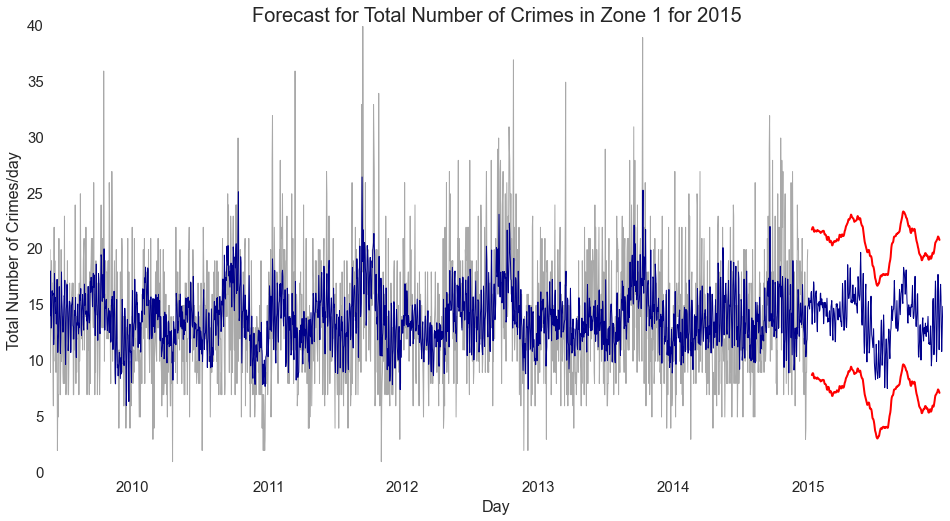

In [712]:
figure = plt.figure(figsize=(16,8))
z1plot =z3TS.plot(linewidth=1, c='darkgray')
z1plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
forecastFits3.plot(linewidth=1,c='darkblue');
z3lower.plot(linewidth=2,c='red');
z3upper.plot(linewidth=2,c='red');
z1plot.set_xlabel('Day',fontsize=16)
z1plot.set_title('Forecast for Total Number of Crimes in Zone 1 for 2015',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)

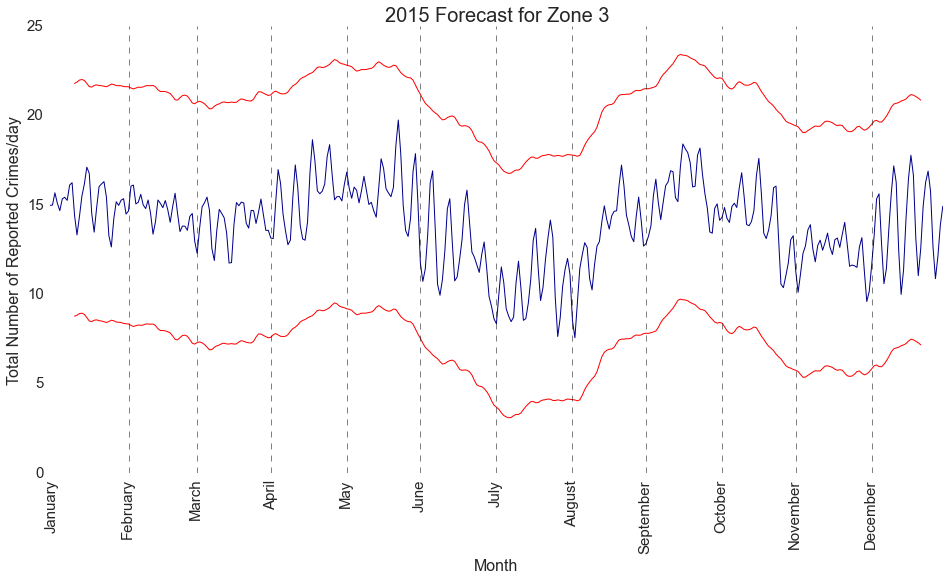

In [747]:
figure = plt.figure(figsize=(16,8))
zoom3 = forecastFits3[(len(forecastFits2)-365):]
zoom3 = pd.Series(forecastFits3[(len(forecastFits3)-365):], index = forecastDFz1['When Reported'][(len(forecastDFz1)-365):])
zoom3[0:] = forecastFits3[(len(forecastFits3)-365):]
z3lower.plot(linewidth=1,c='red');
z3upper.plot(linewidth=1,c='red');

z1plot = zoom3.plot(linewidth=1,c='darkblue');
z1plot.set_xlabel('Month',fontsize=16)
z1plot.set_title('2015 Forecast for Zone 3',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.set_ylabel('Total Number of Reported Crimes/day', fontsize=16)

xlabels = ['January','February','March','April','May','June','July','August','September','October','November','December']
xticks = [1,32,60,90,121,151,182,213,243,274,304,335]

z1plot.set_xticklabels(xlabels, rotation=90, fontsize=15)
z1plot.set_xticks(xticks);

for i in [32,60,90,121,151,182,213,243,274,304,335]:
    plt.axvline(i,0, color='black', ls = '--', linewidth=.5)

#Creating the total crime and forecast model by aggregating the zones 

## Visualization of Total Model

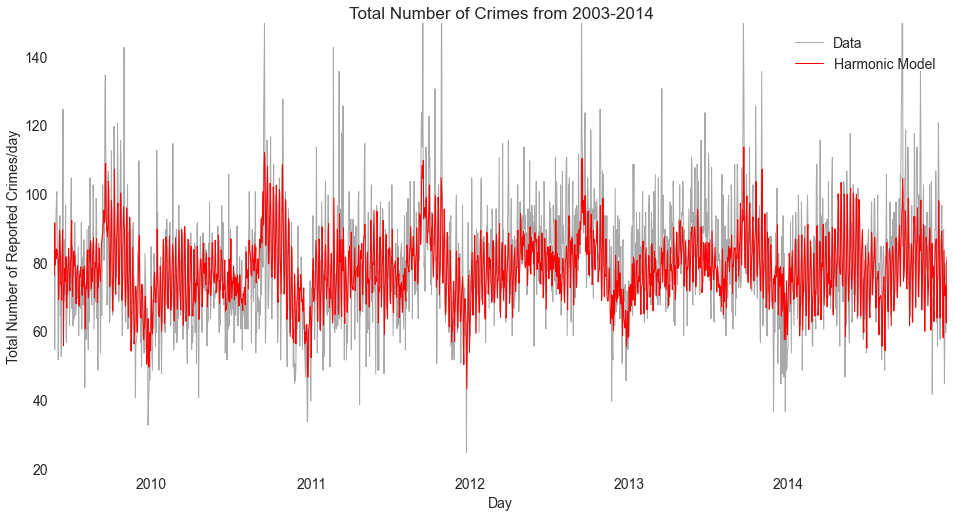

In [733]:
figure = plt.figure(figsize=(16,8))
byDay3=byDay2['2009-05-24':'2014-12-31']
TSPlot = byDay3.plot(linewidth=1, c='darkgray')
plotMeTotal = plotMe1+plotMe2+plotMe3
plotMeTotal.plot(linewidth=1,c='red')

TSPlot.set_ylim(20,150)
TSPlot.set_ylabel('Total Number of Reported Crimes/day', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('Total Number of Crimes from 2003-2014',fontsize=17)
TSPlot.legend(['Data','Harmonic Model'],fontsize=14)
plt.tick_params(axis='both', labelsize=14)

It's still a conservative model, but it's a vast improvement on the FFT model generated from looking at total crime itself.

## Forecast for Total Model

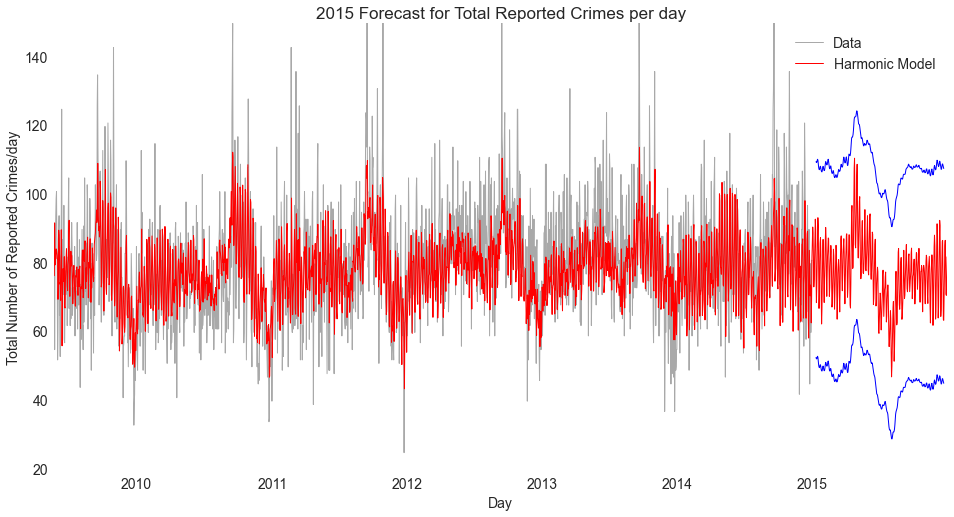

In [737]:
figure = plt.figure(figsize=(16,8))
byDay3=byDay2['2009-05-24':'2014-12-31']
TSPlot = byDay3.plot(linewidth=1, c='darkgray')
forecastFitsTotal = forecastFits+forecastFits2+forecastFits3
forecastFitsTotal.plot(linewidth=1,c='red')

totalLower = z1lower+z2lower+z3lower
totalUpper = z1upper+z2upper+z3upper

totalLower.plot(linewidth=1,c='blue');
totalUpper.plot(linewidth=1,c='blue');

TSPlot.set_ylim(20,150)
TSPlot.set_ylabel('Total Number of Reported Crimes/day', fontsize=14)
TSPlot.set_xlabel('Day',fontsize=14)
TSPlot.set_title('2015 Forecast for Total Reported Crimes per day',fontsize=17)
TSPlot.legend(['Data','Harmonic Model'],fontsize=14)
plt.tick_params(axis='both', labelsize=14)

## Zoomed in Forecast for Total Reported Crimes per day

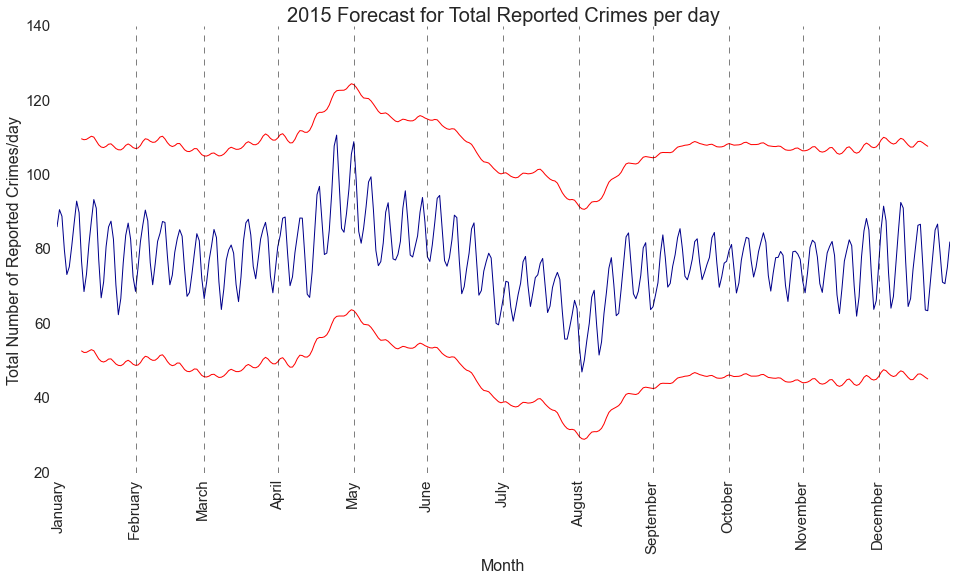

In [750]:
figure = plt.figure(figsize=(16,8))
zoomTotal = zoom+zoom2+zoom3

totalLower.plot(linewidth=1,c='red');
totalUpper.plot(linewidth=1,c='red');

z1plot = zoomTotal.plot(linewidth=1,c='darkblue');
z1plot.set_xlabel('Month',fontsize=16)
z1plot.set_title('2015 Forecast for Total Reported Crimes per day',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.set_ylabel('Total Number of Reported Crimes/day', fontsize=16)

xlabels = ['January','February','March','April','May','June','July','August','September','October','November','December']
xticks = [1,32,60,90,121,151,182,213,243,274,304,335]

z1plot.set_xticklabels(xlabels, rotation=90, fontsize=15)
z1plot.set_xticks(xticks);

for i in [32,60,90,121,151,182,213,243,274,304,335]:
    plt.axvline(i,0, color='black', ls = '--', linewidth=.5)